Copy of a piece of `ml_vs_tswep.ipynb` except errors are in PSSN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth


In [63]:
from lsst.ts.wep.cwfs.tool import ZernikeEval
from lsst.ts.phosim.utils.MetroTool import calc_pssn

In [14]:
# This is different from all other notebooks. Here it's just the Zernike residuals

def calculate_error(pred, truth):
    err = (pred - truth)
    err[~np.isfinite(err)] = np.inf
    return err


In [4]:
df = pd.read_pickle("data/test_dataframe.pkl")
zk = np.load("data/zk_predictions.npz", allow_pickle=True)

# put it all in a dictionary
zk = {key: zk[key] for key in zk.keys()}
zk["ml"] = (zk["mlIntra"] + zk["mlExtra"]) / 2

# fix the truth array
zk["truth"] = np.array([z for z in zk["truth"]])


In [19]:
# create a dataframe with all the info we want to plot
errs = pd.DataFrame()
errs["intraIdx"] = zk["pairs"][:, 0]
errs["extraIdx"] = zk["pairs"][:, 1]
errs["corner"] = df.loc[errs["intraIdx"]]["corner"].to_list()
errs["filter"] = df.loc[errs["intraIdx"]]["filter"].to_list()
errs["seeing"] = df.loc[errs["intraIdx"]]["seeing"].to_list()
errs["airmass"] = df.loc[errs["intraIdx"]]["airmass"].to_list()
errs["intraAngle"] = np.sqrt(
    df.loc[errs["intraIdx"]]["fx"] ** 2 + df.loc[errs["intraIdx"]]["fy"] ** 2
).to_numpy()

errs["vignetting"] = [
    "Mirror vignetting" if angle < 1.74 else "Camera vignetting"
    for angle in errs["intraAngle"]
]

# total blends from intra + extra
blendDmag = df["blendMags"] - df["mag"]
errs["nBrightBlends"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr < 2)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr < 2)).to_numpy()
).astype(int)

errs["nFaintBlends<1"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr < 3)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr < 3)).to_numpy()
).astype(int) - errs["nBrightBlends"]

errs["nFaintBlends>1"] = (
    blendDmag.loc[errs["intraIdx"]].apply(lambda arr: np.sum(arr > 3)).to_numpy()
    + blendDmag.loc[errs["extraIdx"]].apply(lambda arr: np.sum(arr > 3)).to_numpy()
).astype(int)

# calculate the minimum distance to a bright blend
minDist = []
for idx in errs.index:
    dist = np.sqrt(
        np.sum(
            np.square(
                np.hstack(
                    (
                        df.loc[errs["intraIdx"][idx]]["brightBlendOffsets"],
                        df.loc[errs["extraIdx"][idx]]["brightBlendOffsets"],
                    )
                )
            ),
            axis=0,
        )
    )

    if dist.size == 0:
        minDist.append(np.inf)
    else:
        minDist.append(dist.min())
errs["minBrightDist"] = minDist

# minimum SNR in the pair
donut_radius = 62  # pixels
obscuration = 0.61  # fractional
donut_area = np.pi * donut_radius**2 * (1 - obscuration**2)
pixel_scale = 0.2


skyMag = df.loc[errs["intraIdx"]]["skyBrightness"].to_numpy()
skyMag -= 2.5 * np.log10(pixel_scale**2)
maxMag = np.max(
    [
        df.loc[errs["intraIdx"]]["mag"].to_numpy(),
        df.loc[errs["intraIdx"]]["mag"].to_numpy(),
    ],
    axis=0,
)
maxMag += 2.5 * np.log10(donut_area)
snr = 10 ** ((maxMag - skyMag) / (-2.5)) * np.sqrt(donut_area)
errs["snr"] = snr

# save errors in arcseconds
errs["exp"] = list(calculate_error(zk["exp"], zk["truth"]))
errs["ml"] = list(calculate_error(zk["ml"], zk["truth"]))


In [44]:
def clean_errs(
    maxBlends=0,
    minBrightDist=88,
    maxAngle=1.74,
):
    data = errs.copy()
    data = data[
        (data["nBrightBlends"] <= maxBlends)
        & (data["minBrightDist"] > minBrightDist)
        & (data["intraAngle"] < maxAngle)
    ]
    return data


def group_errs(group, upperLim=None, maxErr=np.inf):
    data = clean_errs(
        maxBlends=np.inf if group == "nBrightBlends" else 0,
        minBrightDist=0 if group == "nBrightBlends" else 88,
        maxAngle=np.inf if group == "vignetting" else 1.74,
    )

    if upperLim is not None:
        data[group].clip(None, upperLim, inplace=True)

    keys, exp_vals = map(list, zip(*data.groupby(group)["exp"].apply(list).items()))
    keys, ml_vals = map(list, zip(*data.groupby(group)["ml"].apply(list).items()))

    if group == "filter":
        exp_vals = [exp_vals[keys.index(key)] for key in "ugrizy" if key in keys]
        ml_vals = [ml_vals[keys.index(key)] for key in "ugrizy" if key in keys]
        keys = [key for key in "ugrizy" if key in keys]

    if upperLim is not None:
        keys[-1] = str(keys[-1]) + "+"

    return keys, exp_vals, ml_vals


def plot_violins(
    group,
    xlabel,
    upperLim=None,
    norm=False,
):
    keys, exp_vals, ml_vals = group_errs(group, upperLim, maxErr=2)
    exp_med = np.array([np.median(vals) for vals in exp_vals])
    ml_med = np.array([np.median(vals) for vals in ml_vals])

    if norm:
        exp_vals = [vals / exp_med[0] for vals in exp_vals]
        exp_med /= exp_med[0]
        ml_vals = [vals / ml_med[0] for vals in ml_vals]
        ml_med /= ml_med[0]

    fig, (ax, leg) = plt.subplots(
        1,
        2,
        figsize=(7, 3),
        dpi=150,
        gridspec_kw={"width_ratios": [8, 1]},
        constrained_layout=True,
    )

    # create a violin plot of the errors per-sensor
    positions = np.arange(1, len(keys) + 1)
    ax.violinplot(exp_vals, positions=positions + 0.15, widths=0.25)
    ax.violinplot(ml_vals, positions=positions - 0.15, widths=0.25)

    # plot the medians as stars
    ax.scatter(positions + 0.15, exp_med, marker="*", s=60)
    ax.scatter(positions - 0.15, ml_med, marker="*", s=60)

    # setup labels
    ax.set(
        xlabel=xlabel,
        xticks=positions,
        xticklabels=keys,
        ylabel="Error (nm)",
    )
    ax.xaxis.labelpad = 7
    ax.tick_params(axis="x", length=0)

    # silver lines between panels
    for i in positions[:-1]:
        ax.axvline(i + 0.5, c="silver", ls="-", lw=0.4, zorder=0)

    # create the legend
    leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="TIE")
    leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="DL")
    leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    leg.axis("off")

    return fig, (ax, leg)


def plot_hists(group, title=None, upperLim=None, bins="auto", xmax=1, density=True):
    keys, exp_vals, ml_vals = group_errs(group, upperLim)

    fig, axes = plt.subplots(
        1,
        2,
        figsize=(7, 3),
        dpi=150,
        constrained_layout=True,
    )

    hist_settings = {
        "bins": bins,
        "range": (0, xmax),
        "histtype": "step",
        "alpha": 0.65,
        "density": density,
    }

    for key, vals in zip(keys, exp_vals):
        axes[0].hist(vals, **hist_settings, label=key)
    for key, vals in zip(keys, ml_vals):
        axes[1].hist(vals, **hist_settings, label=key)

    axes[1].legend(title=title)
    axes[0].set(ylabel="Density", xlabel="Error (nm)", title="TIE")
    axes[1].set(xlabel="Error (nm)", title="DL")

    return fig, axes


## 2. Compare DL to exp

In [82]:
grid = np.linspace(-1, 1, 200)
opd_x, opd_y = np.meshgrid(grid, grid)

opd_r = np.sqrt(opd_x**2 + opd_y**2)
mask = opd_r < 1

data = clean_errs()

pssn_exp_list = []
pssn_ml_list = []

for exp, ml, band, airmass in zip(data["exp"], data["ml"], data["filter"], data["airmass"]):
    exp = np.concatenate(([0, 0, 0], exp))
    ml = np.concatenate(([0, 0, 0], ml))

    opd_exp = ZernikeEval(exp, opd_x, opd_y)
    opd_ml = ZernikeEval(ml, opd_x, opd_y)

    wavelen = Bandpass(f"LSST_{band}.dat", "nm").effective_wavelength / 1e3
    
    zen = np.rad2deg(np.arccos(1/airmass))

    pssn_exp = calc_pssn(opd_exp, wavelen, zen=zen)
    pssn_ml = calc_pssn(opd_ml, wavelen, zen=zen)
    
    pssn_exp_list.append(pssn_exp)
    pssn_ml_list.append(pssn_ml)

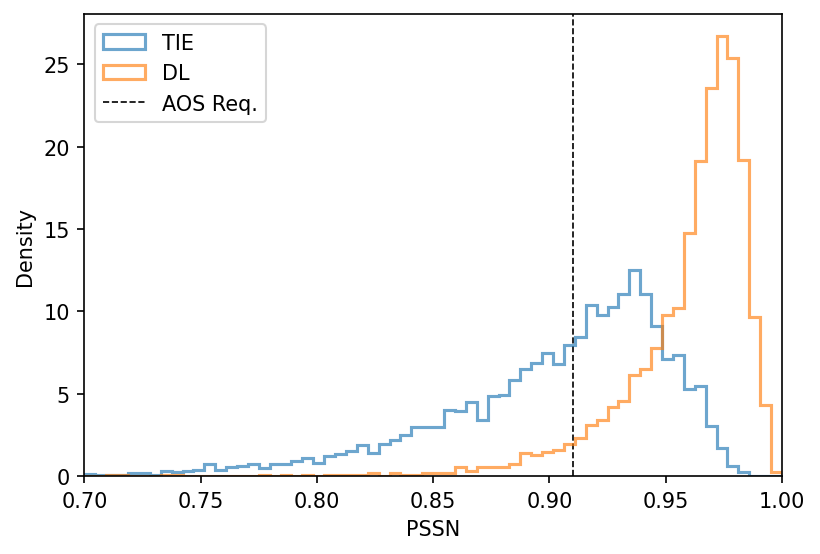

TIE median: 0.8024321726376134
ML median: 0.8906927437324286
ML/TIE: 1.1099913165304685


In [87]:
hist_settings = {
    "bins": 64,
    "range": (0.7, 1),
    "histtype": "step",
    "alpha": 0.65,
    "density": True,
}


fig, ax = plt.subplots(dpi=150, figsize=(6, 4))

# plot ml vs exp for the ideal case
data = clean_errs()
ax.hist(pssn_exp_list, **hist_settings, lw=1.5, label="TIE")
ax.hist(pssn_ml_list, **hist_settings, lw=1.5, label="DL")
ax.axvline(0.91, c="k", ls="--", lw=0.8, zorder=0, label="AOS Req.")
ax.set(xlabel="PSSN", ylabel="Density", xlim=hist_settings["range"])
ax.legend(loc="upper left")

fig.savefig("figures/ideal_tie_vs_ml_pssn.pdf")

plt.show()
print("TIE median:", np.median(pssn_exp))
print("ML median:", np.median(pssn_ml))
print("ML/TIE:", np.median(pssn_ml) / np.median(pssn_exp))
